# Augmentation

> Improving training dynamics even further

Adapted from:

- [https://youtu.be/nlVOG2Nzc3k?si=8a4dKXqkibFS8aHh&t=5063](https://youtu.be/nlVOG2Nzc3k?si=8a4dKXqkibFS8aHh&t=5063)
- [https://www.youtube.com/watch?v=ItyO8s48zdc&t=18s](https://www.youtube.com/watch?v=ItyO8s48zdc&t=18s)

In [1]:
#| default_exp augmentation

In [2]:
# |export
import random
import re
from contextlib import contextmanager
from math import sqrt
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
from einops import rearrange
from IPython.display import Markdown, display
from torch import distributions, nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy
from torchvision import transforms

from slowai.activations import StoreModuleStatsCB, set_seed
from slowai.initializations import init_leaky_weights, set_seed
from slowai.learner import (
    DeviceCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
    batchify,
    def_device,
    fashion_mnist,
)
from slowai.resnets import Conv, ResidualConvBlock
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [3]:
set_seed(42)
plt.style.use("ggplot")

Let's redefine the training loop for clarity.

In [4]:
# |export
def train(model, lr=1e-2, n_epochs=2, dls=fashion_mnist(512), extra_cbs=tuple()):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        MetricsCB(MulticlassAccuracy(num_classes=10)),
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        *extra_cbs,
    ]
    learner = TrainLearner(
        model,
        dls,
        F.cross_entropy,
        lr=lr,
        cbs=cbs,
        opt_func=torch.optim.AdamW,
    )
    learner.fit(n_epochs)

## Going wider

Can we get a better result by increasing the width of our network?

We didn't spend much time designing the Residual CNN from the previous notebook. We simply replaced the Conv blocks with Residual Conv blocks, doubling the number of parameters.

In principle, ResNet's are more stable than their CNN counterparts, so we should be able to make the network wider as well as deeper.

In [5]:
# |export
class ResNet(nn.Module):
    """Arbitrarily wide and deep residual neural network"""

    def __init__(self, nfs: Sequence[int] = [16, 32, 64, 128, 256, 512], n_outputs=10):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs))

    def get_layers(self, nfs, n_outputs=10):
        layers = [ResidualConvBlock(1, nfs[0], stride=1, ks=5)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            layers.append(ResidualConvBlock(c_in, c_out))
        layers.append(ResidualConvBlock(nfs[-1], n_outputs, act=False))
        return layers

    def forward(self, x):
        x = self.layers(x)
        bs, c, w, h = x.shape
        assert c == self.n_outputs
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

MulticlassAccuracy,loss,epoch,train
0.831,0.474,0,train
0.870,0.378,0,eval
0.911,0.241,1,train
0.914,0.233,1,eval


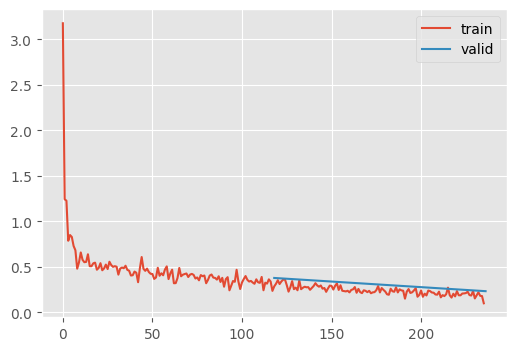

In [6]:
m = ResNet.kaiming()
train(m)

Let's create quick utility to view the shape of the model to check for areas of improvement

In [7]:
# |export
def flops(x, w, h):
    """Estimate flops"""
    if x.dim() < 3:
        return x.numel()
    else:
        return x.numel() * w * h


@contextmanager
def hooks(mods, f):
    hooks_ = []
    for m in mods:
        h = m.register_forward_hook(f)
        hooks_.append(h)
    yield
    for h in hooks_:
        h.remove()


def summarize(m, mods, dls=None, xb_=None):
    if xb is None:
        xb, _ = dls.peek()

        m = m.to(def_device)
        xb = xb.to(def_device)
    else:
        xb = xb_

    tp = 0
    tf = 0
    rows = ["|Type|Input|Output|N. params|MFlops|", "|--|--|--|--|--|"]

    if isinstance(mods, str):
        mods_ = []
        for name, mod in m.named_modules():
            if re.match(mods, type(mod).__name__):
                mods_.append(mod)
        mods = mods_

    def summarize_module(m, i, o):
        nonlocal tp, tf, rows
        (i,) = i
        *_, h, w = o.shape
        np = sum(p.numel() for p in m.parameters())
        tp += np
        nflops = sum(flops(o, h, w) for o in m.parameters()) / 1e6
        tf += nflops
        l = f"| {type(m).__name__} | {tuple(i.shape)} | {tuple(o.shape)} | {np:,} | {nflops:.1f}"
        rows.append(l)

    with hooks(mods, summarize_module), torch.no_grad():
        m(xb)

    rows.append(f"| Total | | | {tp:,} | {tf:} |")
    display(Markdown("\n".join(rows)))

In [8]:
summarize(ResNet(), "ResidualConvBlock")

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| ResidualConvBlock | (8, 1, 28, 28) | (8, 16, 28, 28) | 6,896 | 5.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| ResidualConvBlock | (8, 256, 2, 2) | (8, 512, 1, 1) | 3,672,576 | 3.7
| ResidualConvBlock | (8, 512, 1, 1) | (8, 10, 1, 1) | 52,150 | 0.1
| Total | | | 4,952,582 | |

One of the important constaints of our model here is that that strides must be configured to downsample the image precisely to `bs x c x 1 x 1`. We can make this more flexible by taking the final feature map (regardless of its height and width) and taking the average.

In [9]:
# |export
class GlobalAveragePooling(nn.Module):
    def forward(self, x):
        bs, c, w, h = x.shape
        return x.mean((2, 3))

In [10]:
# |export
class ResNetWithGlobalPooling(nn.Module):
    """Arbitrarily wide and deep residual neural network"""

    def __init__(self, nfs: Sequence[int] = [16, 32, 64, 128, 256, 512], n_outputs=10):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs))
        self.pool = GlobalAveragePooling()
        self.lin = nn.Linear(nfs[-1], n_outputs)
        self.norm = nn.BatchNorm1d(n_outputs)

    def get_layers(self, nfs, n_outputs=10):
        layers = [ResidualConvBlock(1, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            block = ResidualConvBlock(c_in, c_out)
            layers.append(block)
        return layers

    def forward(self, x):
        x = self.layers(x)
        x = self.pool(x)
        x = self.lin(x)
        x = self.norm(x)
        return x

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

In [11]:
nfs = [
    16,
    32,
    64,
    128,
    256,  # 👈 notice that this leaves the feature map at 2x2...
]
m = ResNetWithGlobalPooling.kaiming(nfs)
summarize(m, "ResidualConvBlock|Linear")

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| ResidualConvBlock | (8, 1, 28, 28) | (8, 16, 28, 28) | 6,896 | 5.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| Linear | (8, 256) | (8, 10) | 2,570 | 0.0
| Total | | | 1,230,426 | |

MulticlassAccuracy,loss,epoch,train
0.848,0.581,0,train
0.840,0.477,0,eval
0.913,0.287,1,train
0.916,0.271,1,eval


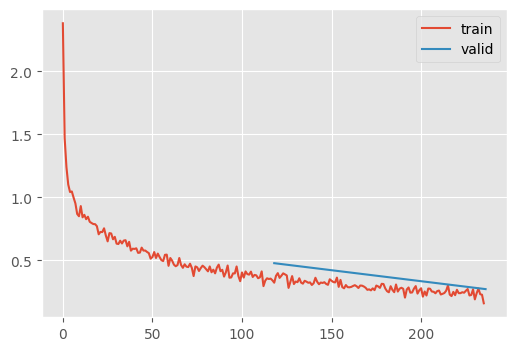

In [12]:
# ...but it still works!
train(m)

Can we reduce the number of parameters to save on memory? Indeed. One thing to focus on is the first ResidualConvBlock which has the most MegaFlops, because it applies the 16 kernels to each pixel. We can try replacing it with a Conv.

In [13]:
# |export
class ResNetWithGlobalPoolingInitialConv(ResNetWithGlobalPooling):
    """Arbitrarily wide and deep residual neural network"""

    def get_layers(self, nfs, n_outputs=10):
        layers = [Conv(1, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            block = ResidualConvBlock(c_in, c_out)
            layers.append(block)
        return layers

In [14]:
m = ResNetWithGlobalPoolingInitialConv.kaiming()
summarize(m, [*m.layers, m.lin, m.norm])

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (8, 1, 28, 28) | (8, 16, 28, 28) | 432 | 0.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| ResidualConvBlock | (8, 256, 2, 2) | (8, 512, 1, 1) | 3,672,576 | 3.7
| Linear | (8, 512) | (8, 10) | 5,130 | 0.0
| BatchNorm1d | (8, 10) | (8, 10) | 20 | 0.0
| Total | | | 4,899,118 | |

MulticlassAccuracy,loss,epoch,train
0.850,0.565,0,train
0.843,0.466,0,eval
0.913,0.281,1,train
0.916,0.265,1,eval


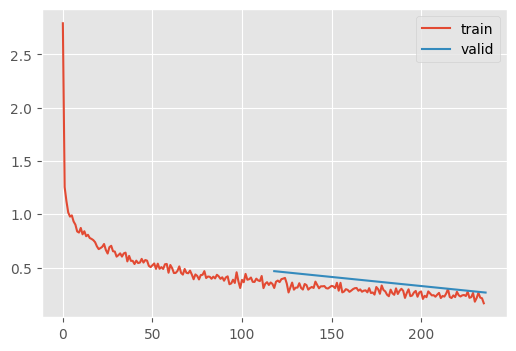

In [15]:
train(m)

This approach yeilds a small, flexible and competitive model. What happens if we train for a while?

MulticlassAccuracy,loss,epoch,train
0.846,0.662,0,train
0.876,0.527,0,eval
0.898,0.456,1,train
0.888,0.411,1,eval
0.907,0.353,2,train
0.888,0.367,2,eval
0.912,0.288,3,train
0.838,0.506,3,eval
0.918,0.250,4,train
0.856,0.418,4,eval


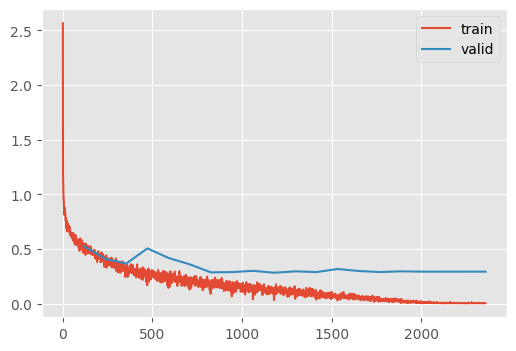

In [16]:
train(ResNetWithGlobalPoolingInitialConv.kaiming(), n_epochs=20)

The near perfect training accuracy indicates that the model is simply memorizing the dataset and failing to generalize.

We've discussed weight decay as a regularization technique. Could this help generalization?

:::{.callout-tip}
## Weight Decay and Batchnorm do not work together
We've posited that weight decay, as a regularization, prevents memorization. However,
batch norm has a single set of coefficients that scale the layer output. Since weight decay also scales the layer weight, the model is able to "cheat." Jeremy says to avoid weight decay and rely on a scheduler.
:::

Instead, let's try "Augmentation" to create pseudo-new data that the model must learn to account for.

## Augmentation

Recall, we implemented the `with_transforms` method on the `Dataloaders` class in the `Learner` notebook.

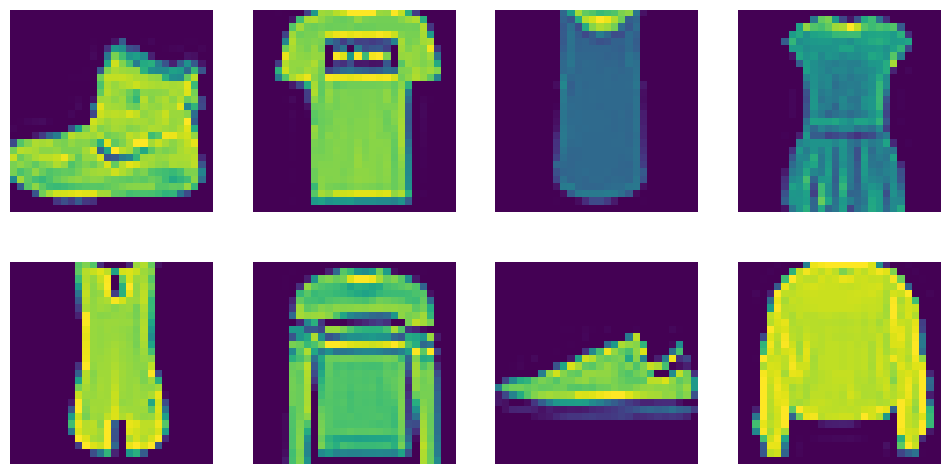

In [17]:
tfms = [
    transforms.RandomCrop(28, padding=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.26], [0.35]),
]
tfmsc = transforms.Compose(tfms)

dls = fashion_mnist(512).with_transforms(
    {"image": batchify(tfmsc)}, lazy=True, splits=["train"]
)

xb, _ = dls.peek()
show_images(xb[:8, ...])

In [18]:
pixels = xb.view(-1)
pixels.mean(), pixels.std()

(tensor(0.0645), tensor(1.0079))

MulticlassAccuracy,loss,epoch,train
0.804,0.762,0,train
0.845,0.568,0,eval
0.875,0.515,1,train
0.869,0.457,1,eval
0.885,0.407,2,train
0.881,0.369,2,eval
0.893,0.339,3,train
0.882,0.352,3,eval
0.900,0.298,4,train
0.856,0.388,4,eval


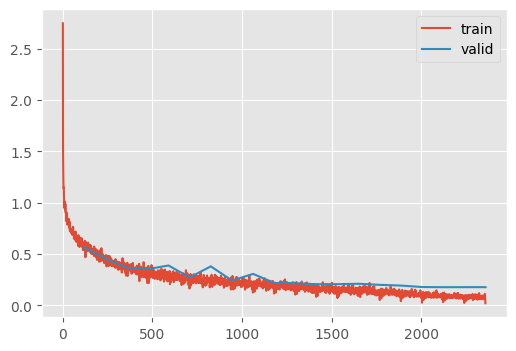

In [19]:
m_with_augmentation = ResNetWithGlobalPoolingInitialConv.kaiming()
train(m_with_augmentation, dls=dls, n_epochs=20)

## Test Time Augmentation

Giving the model mulitple oppertunities to see the input can further improve the output.

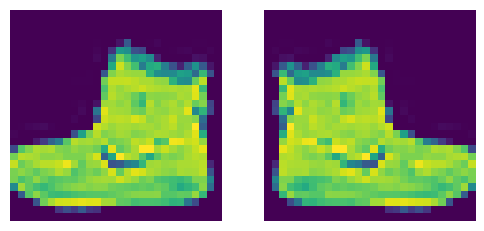

In [20]:
xbf = torch.flip(xb, dims=(3,))
show_images([xb[0, ...], xbf[0, ...]])

In [21]:
def accuracy(model_predict_f, model, device=def_device):
    dls = fashion_mnist(512)
    n, n_correct = 0, 0
    for xb, yb in dls["test"]:
        xb = xb.to(device)
        yb = yb.to(device)
        yp = model_predict_f(xb, model)
        n += len(yb)
        n_correct += (yp == yb).float().sum().item()
    return n_correct / n


def pred_normal(xb, m):
    return m(xb).argmax(axis=1)

Let's check the normal accuracy

In [22]:
accuracy(pred_normal, m_with_augmentation)

0.9415

Now, we can compare that to averaging the outputs when looking at both flips

In [23]:
def pred_with_test_time_augmentation(xb, m):
    yp = m(xb)
    xbf = torch.flip(xb, dims=(3,))
    ypf = m(xbf)
    return (yp + ypf).argmax(axis=1)


accuracy(pred_with_test_time_augmentation, m_with_augmentation)

0.9448

This is a slight improvement!

## RandCopy

Another thing to try is creating new-ish images by cutting and pasting segments of the image onto different locations. A benefit to this approach is that the image should retain its pixel brightness distribution. (Compare to, for example, adding black will push the distribution downwards)

In [24]:
# |export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct = pct
        self.max_num = max_num

    def forward(self, x):
        x = x.clone()
        for i in range(random.randint(0, self.max_num)):
            *_, w, h = x.shape
            szx = int(self.pct * w)
            szy = int(self.pct * h)
            stx1 = int(random.random() * (1 - self.pct) * w)
            sty1 = int(random.random() * (1 - self.pct) * h)
            stx2 = int(random.random() * (1 - self.pct) * w)
            sty2 = int(random.random() * (1 - self.pct) * h)
            segment = x[..., stx2 : stx2 + szx, sty2 : sty2 + szy]
            x[..., stx1 : stx1 + szx, sty1 : sty1 + szy] = segment
        return x

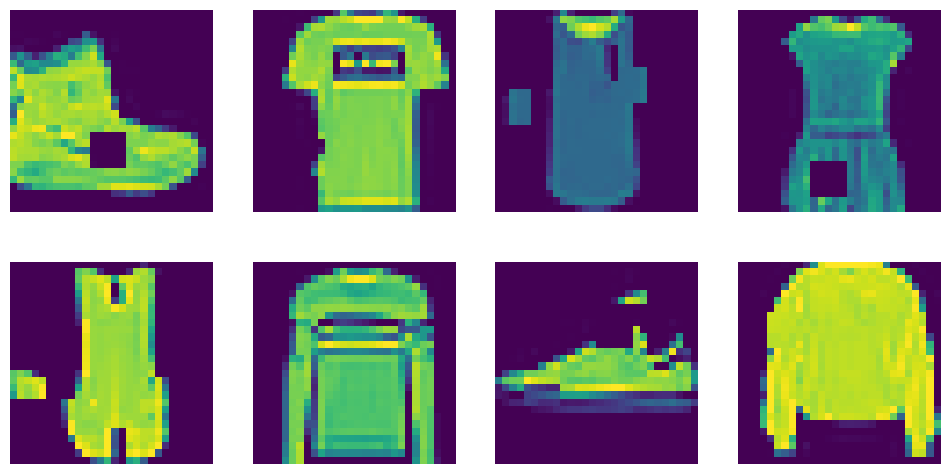

In [25]:
tfmsc2 = transforms.Compose([*tfms, RandCopy()])

dls2 = fashion_mnist(512).with_transforms(
    {"image": batchify(tfmsc2)},
    lazy=True,
    splits=["train"],
)

xb, _ = dls2.peek()
show_images(xb[:8, ...])

MulticlassAccuracy,loss,epoch,train
0.782,0.817,0,train
0.838,0.569,0,eval
0.850,0.576,1,train
0.858,0.459,1,eval
0.865,0.456,2,train
0.852,0.426,2,eval
0.873,0.395,3,train
0.877,0.349,3,eval
0.880,0.348,4,train
0.856,0.410,4,eval


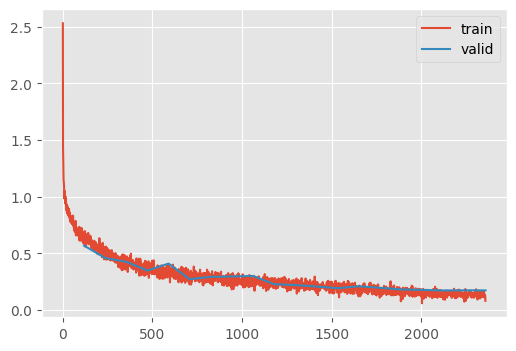

In [26]:
m_with_more_augmentation = ResNetWithGlobalPoolingInitialConv.kaiming()
train(m_with_more_augmentation, dls=dls2, n_epochs=20)

In [27]:
accuracy(pred_normal, m_with_more_augmentation)

0.9383

In [28]:
accuracy(pred_with_test_time_augmentation, m_with_more_augmentation)

0.9414

We're _so_ close to Jeremy's 94.6% accuracy

### Homework: Beat Jeremy

In [29]:
f = RandCopy()


def pred_with_test_time_augmentation_02(xb, m):
    ys = m(xb)
    ys += m(torch.flip(xb, dims=(3,)))
    for _ in range(6):
        ys += m(f(xb))
    return ys.argmax(axis=1)


accuracy(pred_with_test_time_augmentation_02, m_with_more_augmentation)

0.9402

Unfortunately, additional test time augmentation does not seem to improve the results.

Let's try making it deeper.

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (8, 1, 28, 28) | (8, 32, 28, 28) | 864 | 0.6
| ResidualConvBlock | (8, 32, 28, 28) | (8, 64, 14, 14) | 57,664 | 11.2
| ResidualConvBlock | (8, 64, 14, 14) | (8, 128, 7, 7) | 230,016 | 11.2
| ResidualConvBlock | (8, 128, 7, 7) | (8, 256, 4, 4) | 918,784 | 14.7
| ResidualConvBlock | (8, 256, 4, 4) | (8, 512, 2, 2) | 3,672,576 | 14.7
| ResidualConvBlock | (8, 512, 2, 2) | (8, 512, 1, 1) | 4,983,296 | 5.0
| Linear | (8, 512) | (8, 10) | 5,130 | 0.0
| BatchNorm1d | (8, 10) | (8, 10) | 20 | 0.0
| Total | | | 9,868,350 | |

MulticlassAccuracy,loss,epoch,train
0.801,0.767,0,train
0.836,0.539,0,eval
0.861,0.544,1,train
0.880,0.399,1,eval
0.871,0.441,2,train
0.867,0.400,2,eval
0.879,0.375,3,train
0.886,0.346,3,eval
0.889,0.330,4,train
0.847,0.399,4,eval


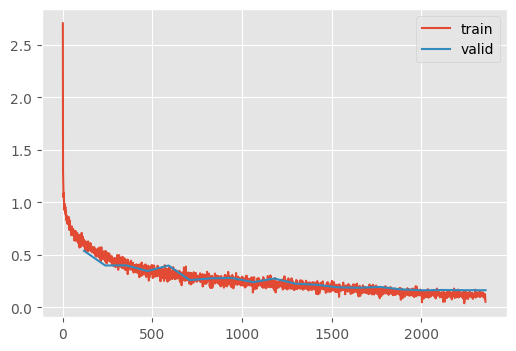

In [30]:
mz = ResNetWithGlobalPoolingInitialConv.kaiming(nfs=[32, 64, 128, 256, 512, 512])
summarize(mz, [*mz.layers, mz.lin, mz.norm])
train(mz, dls=dls2, n_epochs=20)

In [31]:
accuracy(pred_normal, mz)

0.945

In [32]:
accuracy(pred_with_test_time_augmentation, mz)

0.947

Oh, that is just __barely__ better than Jeremy.

I noticed a bug where the initialization is NOT incorporating the GenerualRelu leak parameter. Let's see if that helps.

In [34]:
init_leaky_weights??

Signature: init_leaky_weights(module, leak=0.0)
Docstring: <no docstring>
Source:   
def init_leaky_weights(module, leak=0.0):
    if isinstance(module, (nn.Conv2d,)):
        init.kaiming_normal_(module.weight, a=leak)  # 👈 weirdly, called `a` here
File:      ~/Desktop/SlowAI/nbs/slowai/initializations.py
Type:      function

In [35]:
ResNetWithGlobalPoolingInitialConv().layers[0].act.a

0.1

Let's fix that and see if we can improve the performance.

MulticlassAccuracy,loss,epoch,train
0.795,0.783,0,train
0.859,0.528,0,eval
0.857,0.555,1,train
0.866,0.463,1,eval
0.867,0.450,2,train
0.850,0.445,2,eval
0.877,0.379,3,train
0.894,0.315,3,eval
0.885,0.334,4,train
0.895,0.298,4,eval


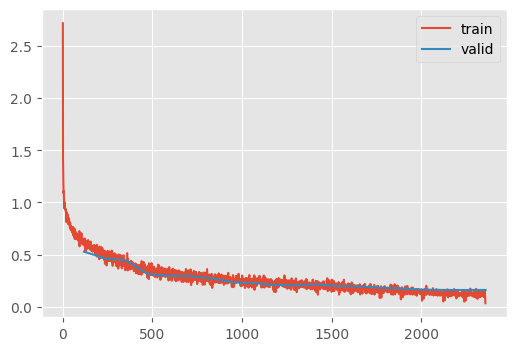

In [36]:
def init_leaky_weights_fixed(m):
    if isinstance(m, Conv):
        if m.act is None or not m.act.a:
            init.kaiming_normal_(m.weight)
        else:
            init.kaiming_normal_(m.weight, a=m.act.a)


class ResNetWithGlobalPoolingInitialConv2(ResNetWithGlobalPoolingInitialConv):
    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights_fixed)
        return model


mz2 = ResNetWithGlobalPoolingInitialConv2.kaiming(nfs=[32, 64, 128, 256, 512, 512])
train(mz2, dls=dls2, n_epochs=20)

In [37]:
accuracy(pred_normal, mz2)

0.9446

In [38]:
accuracy(pred_with_test_time_augmentation, mz2)

0.9473

Sadly, slightly worse for whatever reason.

Let's try a Fixup Initialization

## Fixup initialization

In [39]:
class FixupResBlock(nn.Module):
    def __init__(self, c_in, c_out, ks=3, stride=2):
        super(FixupResBlock, self).__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, ks, 1, padding=ks // 2, bias=False)
        self.conv2 = nn.Conv2d(c_out, c_out, ks, stride, padding=ks // 2, bias=False)
        self.id_conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=1)
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x_orig):
        x = self.conv1(x_orig)
        x = F.relu(x)
        x = self.conv2(x) * self.scale
        if self.conv2.stride == (2, 2):
            x_orig = F.avg_pool2d(x_orig, kernel_size=2, ceil_mode=True)
        x = F.relu(x + self.id_conv(x_orig))
        return x


class FixupResNet(nn.Module):
    def __init__(self, nfs, num_classes=10):
        super(FixupResNet, self).__init__()
        self.conv = nn.Conv2d(1, nfs[0], 5, stride=2, padding=2, bias=False)
        layers = []
        for c_in, c_out in zip(nfs, nfs[1:]):
            layers.append(FixupResBlock(c_in, c_out))
        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(nfs[-1], num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.layers(x)
        bs, c, h, w = range(4)
        x = x.mean((h, w))  # Global Average Pooling
        x = self.fc(x)
        return x

    @torch.no_grad()
    def init_weights(self):
        init.kaiming_normal_(self.conv.weight)
        n_layers = len(self.layers)
        for layer in self.layers:
            (c_out, c_in, ksa, ksb) = layer.conv1.weight.shape
            nn.init.normal_(
                layer.conv1.weight,
                mean=0,
                std=sqrt(2 / (c_out * ksa * ksb)) * n_layers ** (-0.5),
            )
            nn.init.constant_(layer.conv2.weight, 0)
        nn.init.constant_(self.fc.weight, 0)
        nn.init.constant_(self.fc.bias, 0)

    @classmethod
    def random(cls, *args, **kwargs):
        m = cls(*args, **kwargs)
        m.init_weights()
        return m

MulticlassAccuracy,loss,epoch,train
0.333,1.663,0,train
0.643,0.853,0,eval
0.766,0.584,1,train
0.806,0.507,1,eval


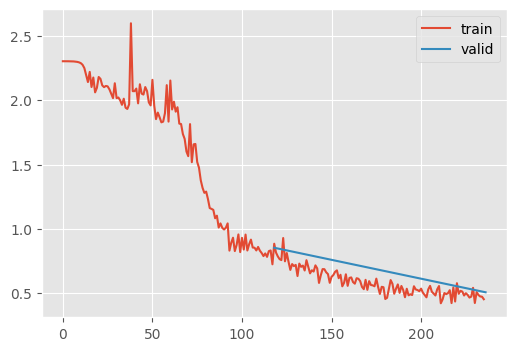

In [40]:
m = FixupResNet.random([8, 16, 32, 64, 128, 256, 512])
stats = StoreModuleStatsCB(m.layers)
train(m, extra_cbs=[stats])

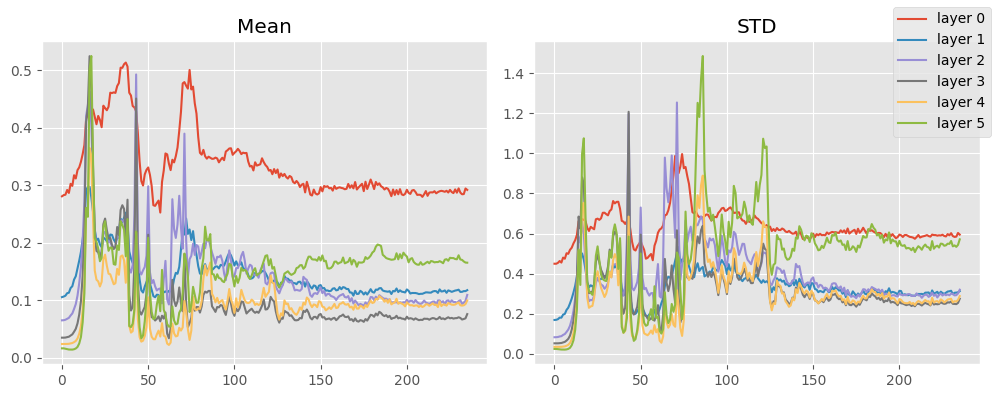

In [41]:
stats.mean_std_plot()

Okay, fixup doesn't look too promising.

[On the forums, some things that were successful](https://forums.fast.ai/t/a-challenge-for-you-all/102656):

- Dropout (and test time dropout augmentation)
- [Curriculum learning](https://arxiv.org/abs/2101.10382)
- [Mish activation](https://github.com/digantamisra98/Mish/issues/37)

This is how you would implement dropout

In [42]:
distributions.binomial.Binomial?

Init signature:
distributions.binomial.Binomial(
    total_count=1,
    probs=None,
    logits=None,
    validate_args=None,
)
Docstring:     
Creates a Binomial distribution parameterized by :attr:`total_count` and
either :attr:`probs` or :attr:`logits` (but not both). :attr:`total_count` must be
broadcastable with :attr:`probs`/:attr:`logits`.

Example::

    >>> # xdoctest: +IGNORE_WANT("non-deterinistic")
    >>> m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
    >>> x = m.sample()
    tensor([   0.,   22.,   71.,  100.])

    >>> m = Binomial(torch.tensor([[5.], [10.]]), torch.tensor([0.5, 0.8]))
    >>> x = m.sample()
    tensor([[ 4.,  5.],
            [ 7.,  6.]])

Args:
    total_count (int or Tensor): number of Bernoulli trials
    probs (Tensor): Event probabilities
    logits (Tensor): Event log-odds
File:           ~/micromamba/envs/slowai/lib/python3.11/site-packages/torch/distributions/binomial.py
Type:           type
Subclasses:     

In [43]:
class Dropout(nn.Module):
    def __init__(self, p=0.9):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return x
        else:
            dist = distributions.binomial.Binomial(1, props=1 - self.p)
            return x * dist.sample(x.shape) / self.p

The difference between `Dropout` and `Dropout2D` is that `Dropout2D` only applies to the width and height dimensions.

In [5]:
#| hide
import nbdev

nbdev.nbdev_export()